In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import pprint as pp

from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
# import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [4]:
def _in(path):
    return os.path.join('data', path)

def _out(path):
    return os.path.join('./', path)

d_src = pd.read_csv(_in('train.csv'))
d_src.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [21]:
t_src = pd.read_csv(_in('test.csv'))
t_src.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


---
### data analysis

In [6]:
# 各列の値
print(d_src.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


ユニークな値の個数を調べる

In [7]:
uniq_of_cols = []

def __is_column_name(u):
    return type(u) == str or type(u) == bool

def show_unique(d, col):
    du = d[col].unique()
    print('------')
    print(col)
    print(d[col].dtype)
    print(du)
    print(len(du))
    # count rows for each unique values
    if len(du) < 20:
        _cc = []
        du = du.tolist()
        for u in du:
            if __is_column_name(u):
                _c = len(d[d[col] == u])
            elif np.isnan(u):
                _c = len(d[d[col].isna()]) 
                du = [x if __is_column_name(x) else 'nan' for x in du]
            else:
                raise Exception(f'{type(u)} is unexpected type')
            _cc.append(int(_c))
            print(f'{u}: {_c}')
        return (col, np.array(du), np.array(_cc))
    else:
        print(f'nan: {len(d[d[col].isna()])}')
        return None
    
print(d_src.columns.values)
for c in d_src:
    u = show_unique(d_src, c)
    if u is not None:
        uniq_of_cols.append(u)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']
------
PassengerId
object
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
8693
nan: 0
------
HomePlanet
object
['Europa' 'Earth' 'Mars' nan]
4
Europa: 2131
Earth: 4602
Mars: 1759
nan: 201
------
CryoSleep
object
[False True nan]
3
False: 5439
True: 3037
nan: 217
------
Cabin
object
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
6561
nan: 199
------
Destination
object
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
4
TRAPPIST-1e: 5915
PSO J318.5-22: 796
55 Cancri e: 1800
nan: 182
------
Age
float64
[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78.

In [8]:
# Cabin列はスラッシュ区切りのため分割してみる
# 客室番号：deck/num/side：sideはP(port=左)とS(starboard=右)
CABIN_COLUMNS = ['Cabin_deck', 'Cabin_num', 'Cabin_side']

def __split_cabin(d):
    return d.split('/')

def split_cabin(d):
    d = d.copy()
    d['Cabin_deck'], d['Cabin_num'], d['Cabin_side'] = np.nan, np.nan, np.nan
    _has_cabin = ~d['Cabin'].isna()
    d.loc[_has_cabin, 'Cabin_deck'], d.loc[_has_cabin, 'Cabin_num'], d.loc[_has_cabin, 'Cabin_side'] = zip(*d[_has_cabin]['Cabin'].apply(__split_cabin))
    return d

d_cab = split_cabin(d_src)
d_cab

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [9]:
for c in CABIN_COLUMNS:
    u = show_unique(d_cab, c)
    if u is not None:
        uniq_of_cols.append(u)

------
Cabin_deck
object
['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
9
B: 779
F: 2794
A: 256
G: 2559
nan: 199
E: 876
D: 478
C: 747
T: 5
------
Cabin_num
object
['0' '1' '2' ... '1892' '1893' '1894']
1818
nan: 199
------
Cabin_side
object
['P' 'S' nan]
3
P: 4206
S: 4288
nan: 199


ユニークな値の個数の分布

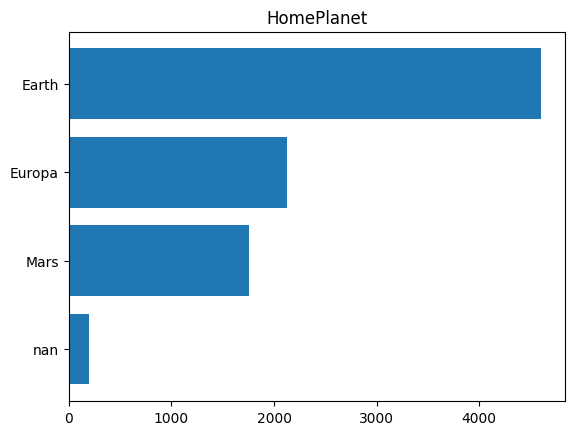

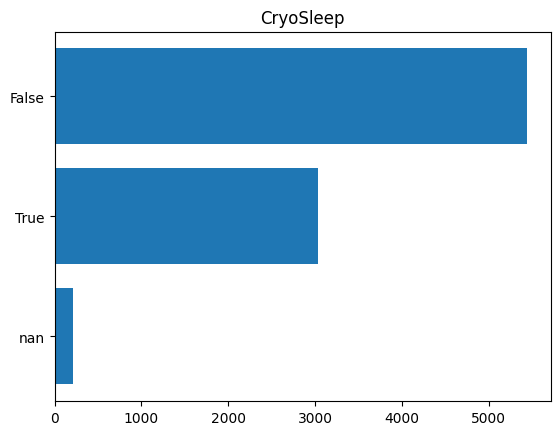

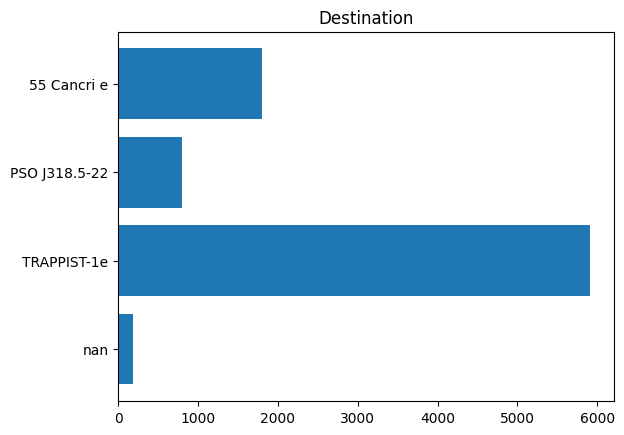

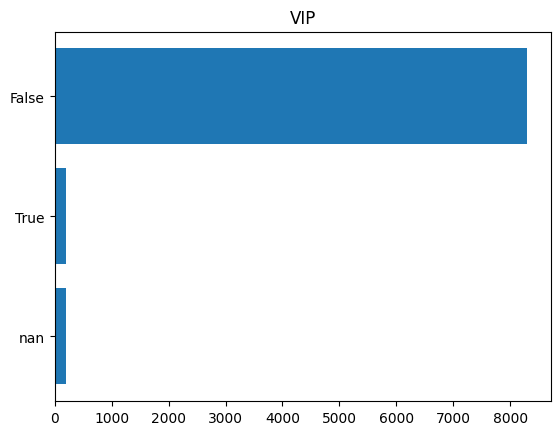

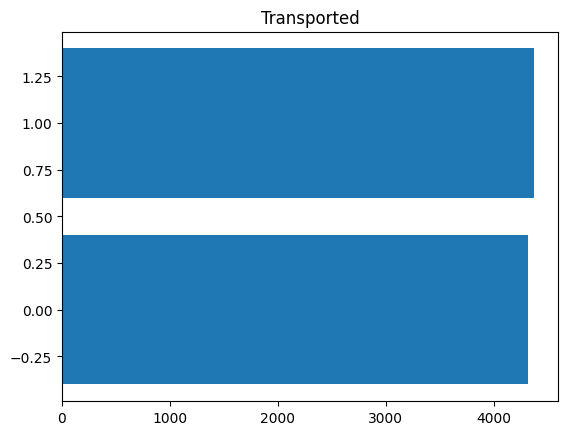

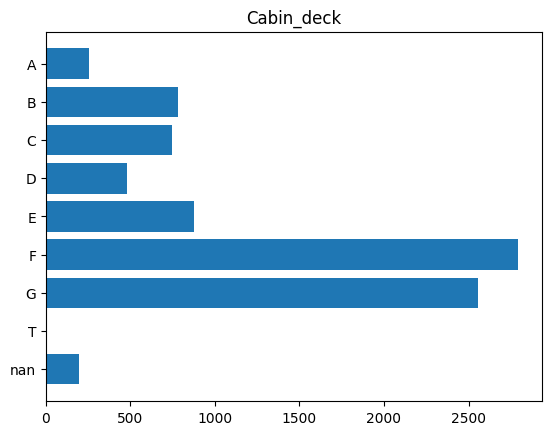

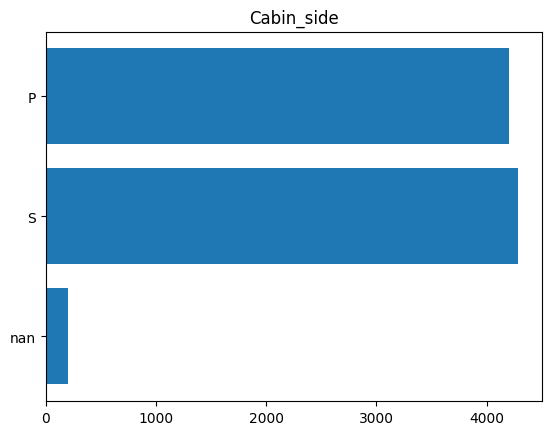

In [10]:
for col, label, value in uniq_of_cols:
    _, ax = plt.subplots()
    label = ['False', 'True'] if type(label[0]) == bool and len(label) == 2 else label
    ax.barh(*zip(*sorted(zip(label, value), reverse=True)))
    ax.set_title(col)
plt.show()

In [11]:
# d = d_cab.copy()
# for i in range(len(uniq_of_cols)):
#     colx, labx, valx = uniq_of_cols[i]
#     for j in range(i + 1, len(uniq_of_cols)):
#         coly, laby, valy = uniq_of_cols[j]
#         dx = d[[colx, coly, 'Transported']].groupby(colx).apply(lambda x: len(x[x['Transported']]))
#         print(dx)
#         dy = d[[coly, 'Transported']].groupby(coly).apply(lambda x: len(x[x['Transported']]))
#         print(dy)
#         _, ax = plt.subplots()
#         sns.heatmap(zip(dx, dy))
#         ax.set_title(f'{colx} - {coly}')
# plt.show()

In [12]:
d = d_src
# いずれかの列に欠損値がある行の数
def count_rows_of_nan_cols(d):
    ttt = d[d.columns[0]].isna()
    for c in d.columns[1:]:
        ttt = ttt | d[c].isna()
    return len(d[ttt])

_cnt = count_rows_of_nan_cols(d)
print(f'any-column-nan rows: {_cnt}/{len(d)} ({_cnt/len(d):.2f})' )

any-column-nan rows: 2087/8693 (0.24)


* データは8693件
* Transportedは半々（予測対象がほぼ均等に分類されている）
    * 学習データのオーバーサンプリングや重み付け等は不要か
* 全データ（行）のうち項目（列）に欠損値のある割合は24%ある
    * 24%を除外するか否か

In [24]:
__gen_boolnum = lambda: {False: 0, True: 1, np.nan: -1}

def __gen_ordna(x):
    r = {k: i for i, k in enumerate(x)}
    r.update({np.nan: -1})
    return r

ordinal_defs = {
    'HomePlanet': __gen_ordna(['Europa', 'Earth', 'Mars']),
    'CryoSleep': __gen_boolnum(),
    'Cabin_deck': __gen_ordna(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']),
    'Cabin_side': __gen_ordna(['P', 'S']),
    'Destination': __gen_ordna(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']),
    'VIP': __gen_boolnum(),
    # 'Transported': __gen_boolnum()
}

for k, v in ordinal_defs.items():
    print(k, v)


HomePlanet {'Europa': 0, 'Earth': 1, 'Mars': 2, nan: -1}
CryoSleep {False: 0, True: 1, nan: -1}
Cabin_deck {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, nan: -1}
Cabin_side {'P': 0, 'S': 1, nan: -1}
Destination {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2, nan: -1}
VIP {False: 0, True: 1, nan: -1}


In [14]:
d = d_cab.copy()

features_ord = ['HomePlanet', 'CryoSleep', 'Cabin_deck', 'Cabin_side', 'Destination', 'VIP']
features_num = ['Cabin_num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def my_ordinal_encode(d):
    for col, defs in ordinal_defs.items():
        d[col] = d[col].map(defs)
    return d

def my_fillna(d):
    for col in features_num:
        d.loc[d[col].isna(), col] = -1
    return d
        
# def _id():
#     d['PassengerId'] = d['PassengerId'].apply(lambda x: int(x.replace('_', '')))
#     d['PassengerId'] = d['PassengerId'].astype(int)

d

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [15]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Cabin_deck    8494 non-null   object 
 15  Cabin_num     8494 non-null   object 
 16  Cabin_side    8494 non-null   object 
dtypes: bool(1), float64(6), object(10)
memory usage: 1.1+ MB


In [26]:
# 学習・予測データとして変換
def prepare_dataset(d, fillna=True):
    d = split_cabin(d)
    d = my_ordinal_encode(d)
    if fillna:
        d = my_fillna(d)
    return d

d = prepare_dataset(d_src)
features = features_ord + features_num
x = d[features]
y = d['Transported']

In [27]:
RANDOM_STATE = 31
rfc = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rfc.fit(x, y)

RandomForestClassifier(random_state=31)

In [28]:
t = t_src.copy()
t = prepare_dataset(t)
t

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_deck,Cabin_num,Cabin_side
0,0013_01,1,1,G/3/S,0,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,6,3,1
1,0018_01,1,0,F/4/S,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,5,4,1
2,0019_01,0,1,C/0/S,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,2,0,1
3,0021_01,0,0,C/1/S,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,2,1,1
4,0023_01,1,0,F/5/S,0,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1,1,G/1496/S,0,34.0,0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,6,1496,1
4273,9269_01,1,0,NaN,0,42.0,0,0.0,847.0,17.0,10.0,144.0,Matty Scheron,-1,-1,-1
4274,9271_01,2,1,D/296/P,2,-1.0,0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,3,296,0
4275,9273_01,0,0,D/297/P,-1,-1.0,0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,3,297,0


In [29]:
test_x = t[features]

pred = rfc.predict(test_x)

submission = pd.DataFrame(zip(t['PassengerId'], pred), columns=['PassengerId', 'Transported'])
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [30]:
submission.to_csv('submission.csv', index=False)